In [1]:
!pip install remotezip Ipython urlib tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
!pip install remotezip

ERROR: Could not find a version that satisfies the requirement urlib (from versions: none)
ERROR: No matching distribution found for urlib
  Preparing metadata (setup.py) ... done
  Using cached remotezip-0.12.3-py3-none-any.whl (8.1 kB)


In [2]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf
import imageio
from IPython import display
import urllib.request as request
from tensorflow_docs.vis import embed

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [4]:
def list_files_from_zip_url(zip_url):
  files=[]
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files


In [5]:
files = list_files_from_zip_url(URL)
files = [ f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [6]:
def get_class_name(fname):
  return fname.split('_')[-3]
def get_files_per_class(files):
  file_class_name = collections.defaultdict(list)
  for fname in files:
    file_class_name[get_class_name(fname)].append(fname)
  return file_class_name

In [7]:
files_for_classes = get_files_per_class(files)
classes = list(files_for_classes.keys())

In [8]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_classes[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [9]:
NUM_CLASSES = 10
FILES_PER_CLASS =50

In [10]:
def select_subset_of_classes(files_for_classes,classes,files_per_classes):
  files_subset = dict()
  for class_name in classes:
    class_file = files_for_classes[class_name]
    files_subset[class_name]= class_file[:files_per_classes]

  return files_subset


In [11]:
file_subset = select_subset_of_classes(files_for_classes,classes[:NUM_CLASSES],FILES_PER_CLASS)
list(file_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [12]:
def  split_class_lists(files_for_class,count):
  split_files=[]
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls]=files_for_class[cls][count:]
  return split_files,remainder

def download_from_zip(zip_url,to_dir,file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class_name(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)


In [28]:
def download_ucf_101_subset(zip_url,num_classes,split,download_dir):
  files=list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens=path.split(os.sep)
    if(len(tokens)<=2):
      files.remove(f)
  files_for_class = get_files_per_class(files)
  classes = list(files_for_class.keys())[:num_classes]
  files_for_class = {x:files_for_class[x] for x in classes}

  dirs={}
  for split_name,split_count in split.items():
    print(split_name,":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir
  return dirs


In [29]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       split = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)


train :


100%|██████████| 300/300 [00:41<00:00,  7.17it/s]


val :


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


test :


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


In [30]:
print(subset_paths)

{'train': PosixPath('UCF101_subset/train'), 'val': PosixPath('UCF101_subset/val'), 'test': PosixPath('UCF101_subset/test')}


In [31]:
def format_frame(frame,output_size):
  frame = tf.image.convert_image_dtype(frame,tf.float32)
  frame = tf.image.resize_with_pad(frame,*output_size)
  return frame
def frames_from_video_files(video_path,n_frame,output_size=(224,224),frame_step=10):
  result=[]
  src = cv2.VideoCapture(str(video_path))
  video_length=src.get(cv2.CAP_PROP_FRAME_COUNT)
  needed_length = 1+(n_frame-1)*frame_step
  if needed_length>video_length:
    start=0
  else:
    max_start = video_length - needed_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES,start)
  ret,frame = src.read()
  result.append(format_frame(frame,output_size))
  for _ in range(n_frame-1):
    for _ in range(frame_step):
      ret,frame = src.read()
    if ret:
      frame = format_frame(frame,output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [32]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv
video_path = "End_of_a_jam.ogv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  27.2M      0  0:00:02  0:00:02 --:--:-- 27.2M


In [33]:
sample_video = frames_from_video_files(video_path,n_frame=10)
sample_video.shape


(10, 224, 224, 3)

In [34]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


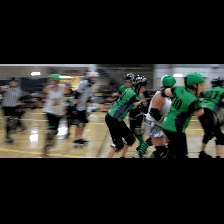

In [35]:
to_gif(sample_video)

In [36]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_files(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [37]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 9
